In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import torch

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("PyTorch:", torch.__version__)


NumPy: 1.26.4
Pandas: 2.3.0
Matplotlib: 3.10.3
Scikit-learn: 1.5.2
TensorFlow: 2.16.2
PyTorch: 2.3.1+cpu


In [2]:
# Load training datasets
landsat_df = pd.read_csv('../dataset/Training/landsat_features_training.csv')
terraclimate_df = pd.read_csv('../dataset/Training/terraclimate_features_training.csv')
water_quality_df = pd.read_csv('../dataset/Training/water_quality_training_dataset.csv')

# Display basic info
print("Landsat Features:", landsat_df.shape)
print("TerraClimate Features:", terraclimate_df.shape)
print("Water Quality:", water_quality_df.shape)

Landsat Features: (9319, 9)
TerraClimate Features: (9319, 4)
Water Quality: (9319, 6)


In [3]:
print("=== Landsat Features (Top 3) ===")
display(landsat_df.head(3))

print("\n=== TerraClimate Features (Top 3) ===")
display(terraclimate_df.head(3))

print("\n=== Water Quality (Top 3) ===")
display(water_quality_df.head(3))

=== Landsat Features (Top 3) ===


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-28.760833,17.730278,02-01-2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595
1,-26.861111,28.884722,03-01-2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134
2,-26.450000,28.085833,03-01-2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805



=== TerraClimate Features (Top 3) ===


,Latitude,Longitude,Sample Date,pet
0,-28.760833,17.730278,02-01-2011,174.2
1,-26.861111,28.884722,03-01-2011,124.1
2,-26.450000,28.085833,03-01-2011,127.5



=== Water Quality (Top 3) ===


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0


In [4]:
# Merge all 3 datasets on common key columns
merged_df = landsat_df.merge(
    terraclimate_df, 
    on=['Latitude', 'Longitude', 'Sample Date'], 
    how='outer'
).merge(
    water_quality_df, 
    on=['Latitude', 'Longitude', 'Sample Date'], 
    how='outer'
)

# Remove duplicate rows
merged_df = merged_df.drop_duplicates()

# Display result
print("Merged DataFrame shape:", merged_df.shape)
print("\nAll columns:", merged_df.columns.tolist())
display(merged_df.head(3))

Merged DataFrame shape: (9319, 13)

All columns: ['Latitude', 'Longitude', 'Sample Date', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'pet', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI,pet,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-34.405833,19.600556,01-10-2014,19002.5,9353.0,13580.0,10717.0,0.166424,-0.18432,173.0,54.181,1008.0,20.0
1,-34.405833,19.600556,02-08-2011,NaN,NaN,NaN,NaN,NaN,NaN,174.1,36.247,1237.0,10.0
2,-34.405833,19.600556,02-12-2015,NaN,NaN,NaN,NaN,NaN,NaN,163.0,57.800,1053.0,20.0


In [ ]:
# Create a copy of merged_df for modeling
model_df = merged_df.copy()

# ============ STEP 1: Check for missing values ============
print("=== Missing Values Before Imputation ===")
print(model_df.isnull().sum())
print(f"\nTotal rows: {len(model_df)}")

# ============ STEP 2: Fill missing values ============
# Numeric columns: fill with mean
# Categorical columns: fill with mode

for col in model_df.columns:
    if model_df[col].isnull().sum() > 0:  # Only process columns with missing values
        if model_df[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            mean_val = model_df[col].mean()
            model_df[col].fillna(mean_val, inplace=True)
            print(f"Filled '{col}' (numeric) with mean: {mean_val:.4f}")
        else:
            mode_val = model_df[col].mode()[0]
            model_df[col].fillna(mode_val, inplace=True)
            print(f"Filled '{col}' (categorical) with mode: {mode_val}")

# ============ STEP 3: Verify no missing values remain ============
print("\n=== Missing Values After Imputation ===")
print(model_df.isnull().sum())

=== Missing Values Before Imputation ===
Latitude                            0
Longitude                           0
Sample Date                         0
nir                              1085
green                            1085
swir16                           1085
swir22                           1085
NDMI                             1085
MNDWI                            1085
pet                                 0
Total Alkalinity                    0
Electrical Conductance              0
Dissolved Reactive Phosphorus       0
dtype: int64

Total rows: 9319
Filled 'nir' (numeric) with mean: 14045.4854
Filled 'green' (numeric) with mean: 9983.2131
Filled 'swir16' (numeric) with mean: 13567.4593
Filled 'swir22' (numeric) with mean: 11425.5384
Filled 'NDMI' (numeric) with mean: 0.0214
Filled 'MNDWI' (numeric) with mean: -0.1443

=== Missing Values After Imputation ===
Latitude                         0
Longitude                        0
Sample Date                      0
nir            

C:\Users\kreddy\AppData\Local\Temp\ipykernel_33084\995236161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df[col].fillna(mean_val, inplace=True)


In [6]:
# ============ STEP 4: Define Features and Targets ============
# Features: Landsat + TerraClimate data
feature_cols = ['nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'pet']

# Targets: Water quality parameters
target_cols = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

X = model_df[feature_cols]
y = model_df[target_cols]

print(f"\nFeatures shape: {X.shape}")
print(f"Targets shape: {y.shape}")


Features shape: (9319, 7)
Targets shape: (9319, 3)


In [7]:
# ============ IMPORTS ============
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============ TRAIN-TEST SPLIT ============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ FEATURE SCALING ============
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

Training samples: 7455
Test samples: 1864


In [8]:
# ============ BUILD MODELS FOR EACH TARGET ============

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Store results
results = {}

# Train and evaluate for each target
for target in target_cols:
    print(f"\n{'='*60}")
    print(f"TARGET: {target}")
    print('='*60)
    
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    results[target] = {}
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train_target)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test_target, y_pred))
        mae = mean_absolute_error(y_test_target, y_pred)
        r2 = r2_score(y_test_target, y_pred)
        
        results[target][model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
        
        print(f"\n{model_name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")


TARGET: Total Alkalinity

Linear Regression:
  RMSE: 69.1919
  MAE:  55.5740
  R²:   0.1408

Ridge Regression:
  RMSE: 69.1913
  MAE:  55.5725
  R²:   0.1408

Lasso Regression:
  RMSE: 69.1900
  MAE:  55.5123
  R²:   0.1409

Random Forest:
  RMSE: 49.9453
  MAE:  35.4273
  R²:   0.5523

Gradient Boosting:
  RMSE: 62.2043
  MAE:  47.9129
  R²:   0.3056

TARGET: Electrical Conductance

Linear Regression:
  RMSE: 323.6214
  MAE:  260.2655
  R²:   0.1467

Ridge Regression:
  RMSE: 323.6222
  MAE:  260.2668
  R²:   0.1467

Lasso Regression:
  RMSE: 323.6351
  MAE:  260.2690
  R²:   0.1467

Random Forest:
  RMSE: 223.8943
  MAE:  151.9457
  R²:   0.5916

Gradient Boosting:
  RMSE: 284.5569
  MAE:  219.9704
  R²:   0.3403

TARGET: Dissolved Reactive Phosphorus

Linear Regression:
  RMSE: 49.9376
  MAE:  38.7529
  R²:   0.0108

Ridge Regression:
  RMSE: 49.9377
  MAE:  38.7528
  R²:   0.0108

Lasso Regression:
  RMSE: 49.9470
  MAE:  38.7765
  R²:   0.0104

Random Forest:
  RMSE: 34.2856
  MA

In [9]:
# ============ RESULTS SUMMARY TABLE ============
print("\n" + "="*80)
print("SUMMARY: Best R² Score for Each Target")
print("="*80)

for target in target_cols:
    best_model = max(results[target], key=lambda x: results[target][x]['R2'])
    best_r2 = results[target][best_model]['R2']
    print(f"\n{target}:")
    print(f"  Best Model: {best_model}")
    print(f"  R² Score:   {best_r2:.4f}")


SUMMARY: Best R² Score for Each Target

Total Alkalinity:
  Best Model: Random Forest
  R² Score:   0.5523

Electrical Conductance:
  Best Model: Random Forest
  R² Score:   0.5916

Dissolved Reactive Phosphorus:
  Best Model: Random Forest
  R² Score:   0.5337


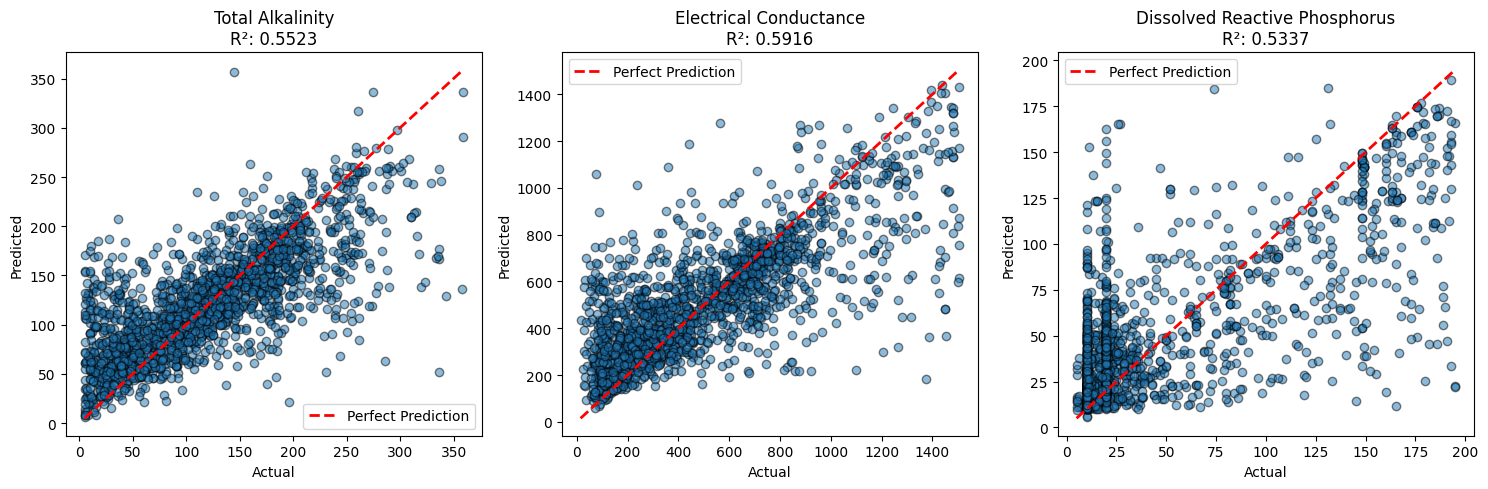

In [10]:
# ============ VISUALIZE PREDICTIONS FOR BEST MODELS ============
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, target in enumerate(target_cols):
    # Use Random Forest for visualization (typically performs well)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train[target])
    y_pred = rf_model.predict(X_test_scaled)
    
    axes[idx].scatter(y_test[target], y_pred, alpha=0.5, edgecolors='k')
    axes[idx].plot([y_test[target].min(), y_test[target].max()], 
                   [y_test[target].min(), y_test[target].max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].set_title(f'{target}\nR²: {r2_score(y_test[target], y_pred):.4f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()